In [57]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import learning_curve
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

In [58]:
import pickle 

# # Đọc dữ liệu bệnh tim, phân loại nhị phân
# with open('preprocessing/heart/X.pkl', 'rb') as f:
#     X = pickle.load(f)
# with open('preprocessing/heart/y.pkl', 'rb') as f:
#     y = pickle.load(f)

with open('preprocessing/cirrhosis/X.pkl', 'br') as f:
    X_train_test = pickle.load(f)

with open('preprocessing/cirrhosis/y.pkl', 'rb') as f:
    label = pickle.load(f)

print('So luong du lieu: ', len(X_train_test))
print('So luong nhan: ', len(label))
X_train_test[0:5]

So luong du lieu:  412
So luong nhan:  412


,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,...,Drug_1,Ascites_0,Ascites_1,Hepatomegaly_0,Hepatomegaly_1,Spiders_0,Spiders_1,Edema_0,Edema_1,Edema_2
0,0.736012,2.547971,-0.547614,-2.125657,0.779134,-0.141082,0.312051,0.879630,-0.704207,1.432617,...,0,0,1,0,1,0,1,0,0,1
1,0.545297,-0.480933,-0.335883,1.511284,-0.578348,2.909990,-0.181213,-0.671780,-0.376028,-0.131446,...,0,1,0,0,1,0,1,1,0,0
2,1.880301,-0.413122,-0.986570,-0.047405,1.497801,-0.787113,-0.532939,-1.281263,-1.117076,1.237109,...,0,1,0,1,0,1,0,0,1,0
3,0.354582,-0.322707,-0.635405,-2.267356,-0.445261,2.225799,-1.249112,-0.597904,-0.778311,-0.424708,...,0,1,0,0,1,0,1,0,1,0
4,-1.171138,0.038953,-0.454659,0.070678,0.606122,-0.703806,-0.188684,-0.967287,-1.275872,0.161816,...,1,1,0,0,1,0,1,1,0,0


<AxesSubplot:ylabel='Stage'>

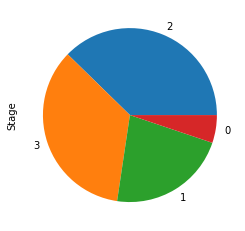

In [59]:
# X_train, X_test, y_train, y_test = train_test_split(X_train_test, label, test_size=0.15, stratify=label, random_state=10)
# X_train
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 0)

train_index, test_index = list(cv.split(X_train_test, label))[0]
X_train, X_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index]
y_train, y_test = label.iloc[train_index], label.iloc[test_index]
y_train.value_counts().plot(kind="pie")

<AxesSubplot:ylabel='Stage'>

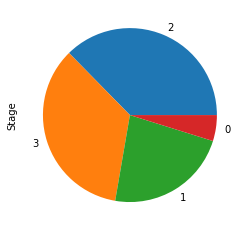

In [60]:
y_test.value_counts().plot(kind="pie")

In [61]:
class KNN:
    def __init__(self, top_k=5):
        self.top_k = top_k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    @staticmethod
    def distance(x1, x2):
        return np.linalg.norm(x1 - x2)

    def predict_batch(self, X):
        y_pred = [self.predict(x) for x in X]
        return y_pred

    def predict(self, x):
        # Compute distance to all points in train set
        distances = [self.distance(x, x_train) for x_train in self.X_train]
        # Sort the distance with index
        top_idx = np.argsort(distances)[:self.top_k]
        # Get top K label
        k_nearests = self.y_train[top_idx]
        # Predict the label
        label = Counter(k_nearests).most_common(1)[0][0]
        
        return label

In [62]:
def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


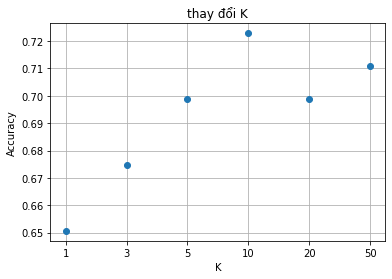

In [63]:
title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []

for k in tqdm([1, 3, 5, 10, 20, 50]):
    # Load model
    model = KNN(top_k = k)
    model.fit(np.array(X_train), np.array(y_train))

    # Sample predict model
    y_pred = model.predict_batch(np.array(X_test))

    # Caculate accuracy score
    acc = accuracy_score(y_pred, np.array(y_test))

    X.append(str(k))
    Y.append(acc)
    error.append(0)

plot(title, xlabel, X, Y, error)
plt.show()

In [64]:
# Test mô hình với K=5, cho độ chính xác cao nhất
model = KNN(top_k = 10)

model.fit(np.array(X_train), np.array(y_train))

# Sample predict model
y_pred = model.predict_batch(np.array(X_test))

# Caculate accuracy score
acc = accuracy_score(y_pred, np.array(y_test))

acc


0.7228915662650602

In [72]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state = 0)
# X_train, X_test, y_train, y_test = train_test_split(X_.values, y_.values, test_size=0.15, stratify=y_.values, random_state=10)

def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train_test, label, cv=cv, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

100%|██████████| 11/11 [00:01<00:00,  8.33it/s]


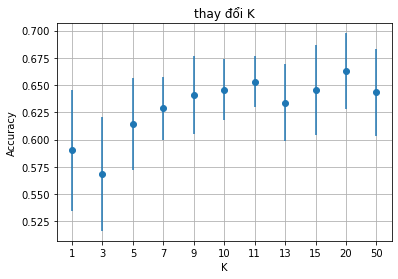

Accuracy max:  0.6626506024096386


In [73]:
title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []

for k in tqdm([1, 3, 5, 7, 9, 10,  11, 13, 15, 20, 50]):
    # Với từng giá trị k nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = KNeighborsClassifier(n_neighbors=k)
    # text_clf = SVC(C=k)
    mean, std = cross_validation(text_clf)
    X.append(str(k))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.show()
print('Accuracy max: ', max(Y))

KNN: 0.6987951807228916


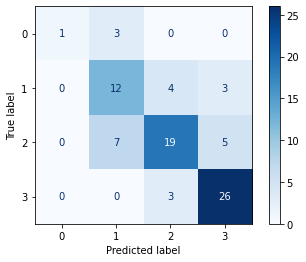

<Figure size 864x864 with 0 Axes>

In [75]:
# Test với bộ tham số tốt nhất
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

print(f'KNN: {accuracy_score(y_test, knn.predict(X_test))}')
# Hiển thị confusion matrix

plot_confusion_matrix(knn, X_test, y_test, cmap = plt.cm.Blues)  
plt.figure(figsize = (12, 12))
plt.show()

In [76]:
# Generating classification report
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.55      0.63      0.59        19
           2       0.73      0.61      0.67        31
           3       0.76      0.90      0.83        29

    accuracy                           0.70        83
   macro avg       0.76      0.60      0.62        83
weighted avg       0.71      0.70      0.69        83



In [69]:
# from sklearn.metrics import precision_score, recall_score
# recall_s = recall_score(y_test, knn.predict(X_test), average=None)
# print('Tỉ lệ dự đoán đúng người bị bệnh là ', recall_s[1])
# print('Tỉ lệ dự đoán đúng người không bị bệnh là', recall_s[0])